In [152]:
from torch import set_grad_enabled, clamp, matmul, Tensor, sum, ones, randn, empty, max, exp, addmm, log, zeros_like, zeros
from torch.nn.init import normal_
from random import uniform
from math import pi, sqrt
import math
import matplotlib.pyplot as plt
import numpy as np
import random
#%matplotlib notebook

### _I - Setting up_

In [153]:
# Turn off autograd
set_grad_enabled(False)

In [154]:
# Generates a data point sampled uniformly in [0,1]
# If the data is inside the disk centered at (0.5,0.5) of radius 1/2*pi, its label must be 1, else 0
def gen_point():
    center_x, center_y = 0.5, 0.5
    R = 1/sqrt(2*pi)
    rand_x, rand_y = uniform(0, 1), uniform(0, 1)
    label = 0
    if (rand_x - center_x) ** 2 + (rand_y - center_y) ** 2 <= R ** 2: #inside
        label = 1
    return [rand_x, rand_y], label

# Generates N points
def gen_points(N):
    pts = []
    labels = []
    for _ in range(N):
        pt, label = gen_point()
        pts.append(pt)
        labels.append(label)
    return pts, labels


In [155]:
# One-hot encodes y
def convert_to_one_hot(y):
    y_onehot = empty(y.size(0), 2) #2 because boolean one hot
    y_onehot.zero_()
    y_onehot[range(y.size(0)), y.long()] = 1
    return Tensor(y_onehot)

In [156]:
# One-hot decodes y
def decode_one_hot(y_onehot):
    y = empty(y_onehot.size(0))
    y = Tensor([0. if x[0]==1 else 1. for x in y_onehot])
    return y

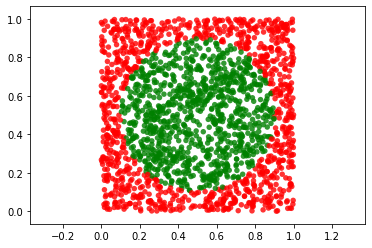

In [157]:
# Generate 1k samples of training data + 1k samples of testing data
all_points, all_labels = gen_points(2000)

# Plot the data
fig, ax = plt.subplots()
plt.axis('equal')
for p,r in zip(all_points, all_labels):
    ax.scatter(p[0], p[1], alpha=0.8, c='green' if r else 'red', edgecolors='none', s=30)

In [158]:
# Convert to tensors
all_points = Tensor(all_points)               # points = datapoint (x and y position)
all_labels = Tensor(all_labels)               # labels = 0 if the point is inside the disk, 1 if outside
all_targets = convert_to_one_hot(all_labels)  # targets = one hot encodings of the labels

# Split the dataset
train_pts, test_pts = all_points[:1000], all_points[1000:]
train_labels, test_labels = all_labels[:1000], all_labels[1000:]
train_targets, test_targets = all_targets[:1000], all_targets[1000:]

In [159]:
# Normalize the datasets
mean,std = train_pts.mean(), train_pts.std()
train_pts.sub_(mean).div_(std)
test_pts.sub_(mean).div_(std)

tensor([[-0.8315, -1.5235],
        [ 1.1572,  1.3008],
        [ 1.4807,  0.1192],
        ...,
        [ 0.2566, -1.0849],
        [-0.9050,  0.4447],
        [ 1.3272,  1.2203]])

### _II - Defining network structures_

In [176]:
# Interface
class Module (object):
    def __init__(self):
        self.x = None           # The input to the current module
        self.prev_grad = None   # Gradient at the output of this module
    
    # Forward-pass method
    def forward (self, x):
        raise NotImplementedError
        
    # Backward propagation method
    def backward (self, prev_grad):
        raise NotImplementedError
        
    # Update method
    def step(self, lr, weight_decay):
        raise NotImplementedError
        
    def get_weights(self):
        raise NotImplementedError

In [177]:
# Fully connected layer
class Linear(Module):
    def __init__(self, in_dim, out_dim, method='random'):
        super().__init__()
        #  Scale with 0.2 not to have inf values and losses  

        if method == 'random':
            self.w = randn(in_dim, out_dim) * 0.2 # Random weights from normal dist
            self.b = randn(1, out_dim) * 0.2      # Random bias from normal dist

        elif method == 'he':
            self.w = randn(in_dim, out_dim)*sqrt(2/in_dim) * 0.2
            self.b = randn(1, out_dim) * 0.2

        elif method == 'xavier':
            self.w = randn(in_dim, out_dim)*sqrt(1/in_dim) * 0.2
            self.b = randn(1, out_dim) * 0.2

        elif method == 'zeros':
            self.w = zeros((in_dim, out_dim))
            self.b = zeros((1, out_dim))

        else:
            raise NotImplementedError("Initialization method not implemented")
        
        #print('w', self.w)
        #print('b', self.b)
        
    def forward(self, x):
        self.x = x
        return addmm(self.b, x, self.w)        # Without an activation function
        #return (x @ self.w) + self.b          # Without an activation function
    
    def backward(self, prev_grad): # add wd as parameter in all the backward
        self.prev_grad = prev_grad             # Cache the grad at the output for weight update.      
        current_grad = (prev_grad @ self.w.t()) #.add_(wd, self.w)   
        return current_grad                                          
        
    def step(self, lr, weight_decay):
        self.w -= lr * (self.x.t() @ self.prev_grad)    # Multiply the grad at output with dy/dw to update the weights
        self.w -= lr * (weight_decay * self.w)
        self.b -= lr * (self.prev_grad.sum(dim=0))      # dy/db = 1. then dL / db = dy, which is the grad at the output
    
    def get_weights(self):
        return self.w

In [178]:
# Sequential structure to combine several modules
class Sequential(Module):
    def __init__(self, module_list):
        self.module_list = module_list
        
    def forward(self, x):
        out = self.module_list[0].forward(x)
        for module in self.module_list[1:]:
            out = module.forward(out)
        return out
    
    def backward(self, gradwrtoutput):
        for model in self.module_list[::-1]:
            gradwrtoutput = model.backward(gradwrtoutput)
            
    def step(self, lr, weight_decay = 0):
        for module in self.module_list:
            module.step(lr, weight_decay)
            
    def get_weights(self):
        weights = []
        for module in self.module_list:
            m_weight = module.get_weights()
            if (m_weight == None):
                continue
            weights += [module.get_weights()]
        return weights

### _III - Defining activation functions_

In [179]:
# ReLu activation function
class ReLU(Module):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        self.x = x
        return x.clamp(min = 0)       # Negative values -> 0, positive values stay the same (relu = max(0,x))
    
    def backward(self, prev_grad):
        self.prev_grad = prev_grad    # Cache the gradient at the output 
        curr_grad = prev_grad.clone() # Copy it for returning the new gradient
        curr_grad[self.x < 0] = 0     # Relu = max(0,x), grad_relu = 0 if x <= 0 else 1
        return curr_grad
    
    def step(self, lr, weight_decay):
        pass    
    
    def get_weights(self):
        pass

In [201]:
# Leaky ReLu activation function
class LeakyReLU(Module):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        self.x = x
        #return x.clamp(min = 0.01 * x)
        return max(0.01 * x, x)
    
    def backward(self, prev_grad):
        self.prev_grad = prev_grad    # Cache the gradient at the output 
        curr_grad = prev_grad.clone()
        curr_grad[self.x < 0] = 0.01
        return curr_grad
    
    def step(self, lr, weight_decay):
        pass    
    
    def get_weights(self):
        pass

In [202]:
# Tanh activation function
class Tanh(Module):
    
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        self.x = x
        return (exp(x) - exp(-x)) / (exp(x) + exp(-x))                         # Tanh function
    
    def backward(self, prev_grad):
        self.prev_grad = prev_grad                                             # Cache the gradient at the output
        tanh_x = (exp(self.x) - exp(-self.x)) / (exp(self.x) + exp(-self.x))   # Tanh of x
        curr_grad = prev_grad * (1 - (tanh_x)**2)                              # Current gradient 
        return curr_grad
    
    def step(self, lr, weight_decay):
        pass

    def get_weights(self):
        pass

In [203]:
# Sigmoid activation function
class Sigmoid(Module):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        self.x = x
        return 1 / (1 + exp(-x))                              # Sigmoid function
    
    def backward(self, prev_grad):
        self.prev_grad = prev_grad                            # Cache the gradient at the output 
        sigmoid_x = 1 / (1 + exp(-self.x))                    # Sigmoid of x
        curr_grad = prev_grad * sigmoid_x * (1 - sigmoid_x)   # Current gradient
        return curr_grad

    def step(self, lr, weight_decay):
        pass
    
    def get_weights(self):
        pass

### _IV - Defining  cost functions_

In [127]:
# Computes the Mean Squared Error & Gradient at output
def mse(pred, target):
    return sum((pred - target)**2),  2* (pred-target)

In [128]:
# Softmax function stabilized by taking x = x-max(x)
def softmax(x):
    return exp(x-max(x))/sum(exp(x-max(x)))

# Computes the Cross Entropy Loss
def crossEntropyLoss(pred, target):
    return -sum(target*softmax(pred).log()), pred-target

### _V - Training and measuring performance_

In [129]:
# Fixing the seed
SEED = 1
randn.seed(SEED)
#torch.manual_seed(SEED)

AttributeError: 'builtin_function_or_method' object has no attribute 'seed'

In [266]:
# Instanciates a model with respect to the model id given as input to the function
def model_selector(mid):
    # Relu activation
    if mid == 0:
        #model = Sequential([Linear(2, 25), ReLU(), Linear(25,25), ReLU(), Linear(25,25, method = 'xavier'), ReLU(), Linear(25,2), LeakyReLU()])
        model = Sequential([Linear(2, 25), ReLU(), Linear(25,25), ReLU(), Linear(25,25), ReLU(), Linear(25,2), ReLU()])
        return model
    # Sigmoid activation
    elif mid == 1:
        model = Sequential([Linear(2, 25), ReLU(), Linear(25,25), ReLU(), Linear(25,25), ReLU(), Linear(25,2), Sigmoid()])
        return model
    # Tanh activation
    elif mid == 2:
        model = Sequential([Linear(2, 25), ReLU(), Linear(25,25), ReLU(), Linear(25,25), ReLU(), Linear(25,2), Tanh()])
        return model     
    # Softmax activation (included in the cross entropy)
    elif mid == 3:
        model = Sequential([Linear(2, 25), ReLU(), Linear(25,25), ReLU(), Linear(25,25), ReLU(), Linear(25,2)])
        return model
    # Leaky relu activation
    elif mid == 4:
        model = Sequential([Linear(2, 25), LeakyReLU(), Linear(25,25),LeakyReLU(), Linear(25,25), LeakyReLU(), Linear(25,2), LeakyReLU()])
        return model

In [131]:
# Batch generator
def data_generator(pts, targets, labels, batch_size):
    data_len = pts.size(0)
    i = 0
    while i < data_len:
        j = i + batch_size if i +batch_size < data_len else data_len
        yield pts[i:j], targets[i:j], labels[i:j]
        i = j

In [214]:
# Trains the model over n epochs with mini batch processing
def train(model, train_pts, train_targets, n_epoch, lr0, test_pts = [], test_targets = [], 
          train_history = False, test_history = False, weight_decay = 0, lr_decay_type='exponential', lr_decay = 0, 
          criterion = 'MSE', batch_size = 1000, optimizer = 'MiniBatch'):
    
    # History
    model_history = dict()
    
    # Loss histories
    train_losses = []
    test_losses = []
    
    # Accuracy histories
    train_accs = []
    test_accs = []
    
    # Labels (needed if the accuracies are computed)
    train_labels = []
    test_labels = []
    if (train_history):
        train_labels = decode_one_hot(train_targets)
    if (test_history):
        test_labels = decode_one_hot(test_targets)
    
    # Train for n epochs
    for e in range(n_epoch):
        epoch_train_loss = 0 
        
        # Learning rate decay
        if lr_decay_type == 'exponential':
            lr = lr0 * math.exp( -lr_decay * n_epoch)
        if lr_decay_type == 'time-based':
            lr *= (1. / (1. + lr_decay * n_epoch))
        if lr_decay_type == 'step-decay':
            lr = lr0 * math.pow(0.5,math.floor((1+n_epoch)/10))
        
        # Generate batches
        generator = data_generator(train_pts, train_targets, train_labels, batch_size)
        
        # For each batch
        for i, (t_pts, ts, t_labels) in enumerate(generator):
            
            # Forward pass
            train_pred = model.forward(t_pts)
            
            # Compute loss
            if(criterion=='MSE'):
                train_loss, grad_at_output = mse(train_pred, ts.view(-1, 2))
            elif(criterion=='CROSSENTROPY'):
                train_loss, grad_at_output = crossEntropyLoss(train_pred, ts.view(-1, 2))
            else:
                raise NotImplementedError("Criterion not implemented")
        
            # Weight decay
            weights = model.get_weights()
            l2_penality = 0
            for w in weights:
                l2_penality += (w**2).sum()
            train_loss += weight_decay * l2_penality/2
            
            # Backward prop
            model.backward(grad_at_output)             # grad_at_output += wd*w
            model.step(lr, weight_decay = weight_decay)
            epoch_train_loss += train_loss.item()
            
        # If we want to keep histories about training loss & accuracy               
        if (train_history):
                train_losses.append(epoch_train_loss)
                train_accs.append(compute_acc(model, t_pts, t_labels, train_pred)) 
        
        # If we want to keep histories about testing loss & accuracy
        if (test_history):
            
            # Forward pass
            test_pred = model.forward(test_pts)
            
            # Compute loss
            if(criterion=='MSE'):
                test_loss, _ = mse(test_pred, test_targets.view(-1, 2))
            elif(criterion=='CROSSENTROPY'):
                test_loss, _ = crossEntropyLoss(test_pred, test_targets.view(-1, 2))
            else:
                raise NotImplementedError("Criterion not implemented")
            
            #test_loss += wd * (w**2).sum()/2
            test_losses.append(test_loss.item())
            test_accs.append(compute_acc(model, test_pts, test_labels, test_pred))

            
        
    # If we want to keep histories about training
    if (train_history):
        model_history['train_loss'] = train_losses
        model_history['test_loss'] = test_losses
    
    # If we want to keep histories about testing
    if (test_history):
        model_history['train_accuracy'] = train_accs
        model_history['test_accuracy'] = test_accs
        
    return model_history

In [215]:
# Computes accuracy
def compute_acc(model, pts, labels, pred):
    n_samples = pts.size(0)
    _, indices = max(pred.view(-1,2), 1)
    accuracy = (sum(indices.view(-1,1) == labels.view(-1, 1)) / float(n_samples) * 100).item()
    return accuracy

In [258]:
# Test the performance of the relu only model with tuned hyper parameters

model_relu = model_selector(0)
history_relu = train(model_relu, train_pts, train_targets, 250, 0.00007, test_pts = test_pts, test_targets = test_targets, 
                     train_history = True, test_history = True, weight_decay = 0, criterion = 'MSE')
acc_relu = compute_acc(model_relu, test_pts, test_labels, model_relu.forward(test_pts))
print(acc_relu)

72.89999389648438


In [250]:
# Test the performance of the sigmoid model with tuned hyper parameters 

model_sigmoid = model_selector(1)
history_sigmoid = train(model_sigmoid, train_pts, train_targets, 250, 0.005, test_pts = test_pts, test_targets = test_targets, 
                        train_history = True, test_history = True, weight_decay = 0, criterion = 'MSE', batch_size = 500)
acc_sigmoid = compute_acc(model_sigmoid, test_pts, test_labels, model_sigmoid.forward(test_pts))
print(acc_sigmoid)

96.80000305175781


In [232]:
# Test the performance of the tanh model with tuned hyper parameters

model_tanh = model_selector(2)
history_tanh = train(model_tanh, train_pts, train_targets, 250, 0.0001, test_pts = test_pts, test_targets = test_targets, 
                     train_history = True, test_history = True, criterion = 'MSE')
acc_tanh = compute_acc(model_tanh, test_pts, test_labels, model_tanh.forward(test_pts))
print(acc_tanh)

97.19999694824219


In [233]:
# Test the performance of the softmax model with tuned hyper parameters

model_soft = model_selector(3)
history_soft = train(model_soft, train_pts, train_targets, 250, 0.0001, test_pts = test_pts, test_targets = test_targets, 
                     train_history = True, test_history = True, criterion = 'CROSSENTROPY')
acc_soft = compute_acc(model_soft, test_pts, test_labels, model_soft.forward(test_pts))
print(acc_soft)

97.29999542236328


In [267]:
# Test the performance of the leaky relu model with tuned hyper parameters

model_leaky = model_selector(4)
history_leaky = train(model_leaky, train_pts, train_targets, 250, 0.0001, test_pts = test_pts, test_targets = test_targets, 
                     train_history = True, test_history = True, criterion = 'MSE')
acc_soft = compute_acc(model_leaky, test_pts, test_labels, model_soft.forward(test_pts))
print(acc_soft)

97.29999542236328


In [243]:
def simple_plot(history, model_name, train_history = False, test_history = False):
    train_losses = history['train_loss']
    test_losses = history['test_loss']
    train_accs = history['train_accuracy']
    test_accs = history['test_accuracy']
    
    plt.figure(figsize=(10,8))
    
    if (train_history):
        plt.plot(train_losses, alpha = 0.5, color = 'b', linewidth = 2.0, label = model_name + " Training Loss")
            
    if (test_history):
        plt.plot(test_losses, alpha = 0.5, color = 'g', linewidth = 2.0, label = model_name + " Testing Loss")
            
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,8))
    
    if (train_history):
        plt.plot(train_accs, alpha = 0.5, color = 'b', linewidth = 2.0, label = model_name + " Training Loss")

    if (test_history):
        plt.plot(test_accs, alpha = 0.5, color = 'g', linewidth = 2.0, label = model_name + " Testing Loss")
            
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

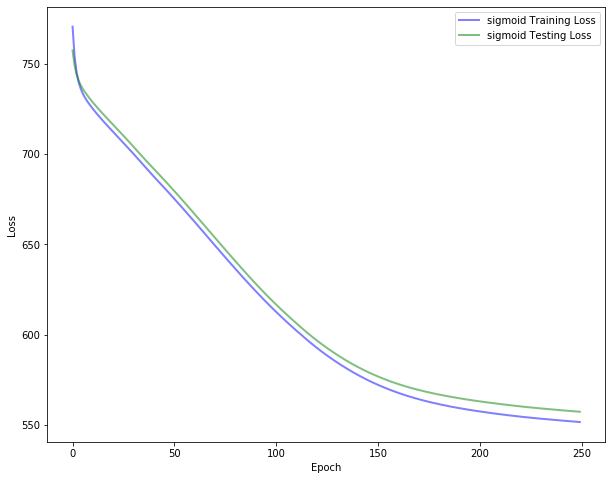

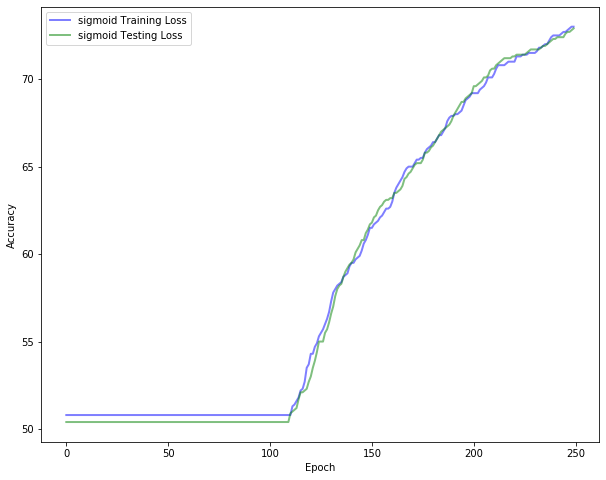

In [259]:
simple_plot(history_relu, 'sigmoid', train_history = True, test_history = True)

### VI - Hyper-parameter tuning

In [287]:
# Performs a k-fold cross validation
def cross_val_score(mid, train_pts, train_labels, train_targets, n_epoch, lr, k_folds=5, batch_size = 1000, criterion = 'MSE'):
    len_train = train_pts.size(0)
    indices = [i for i in range(len_train)]
    random.seed(8)
    random.shuffle(indices)
    accs = []
    for k in range(k_folds):
        model = model_selector(mid)  # Init the same model
        
        val_indices = indices[k*len_train//k_folds:(k+1)*len_train//k_folds] # 1 validation fold
        train_indices = list(set(indices) - set(val_indices))                # k-1 training fold
        
        # Train the model with k-1 training fold
        history = train(model, train_pts[train_indices], train_targets[train_indices], n_epoch, lr, criterion = criterion, batch_size = batch_size)
        
        # Compute the accuracy on 1 validation fold
        acc = compute_acc(model, train_pts[val_indices], train_labels[val_indices], model.forward(train_pts[val_indices])) 
        accs.append(acc)
        #print('fold=', k, ' acc = ', acc)
    return Tensor(accs).mean()

In [288]:
def grid_search(mid, lrs, criterion = 'MSE'):
    #lrs = [0.00001, 0.00002, 0.00003, 0.00004, 0.00005, 0.00006, 0.00007, 0.00008, 0.00009]
    #lrs = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005]
    epochs = [50,100,150,200,250]
    for epoch in epochs:
        for lr in lrs:
            avg = cross_val_score(mid, train_pts, train_labels, train_targets, epoch, lr, criterion = criterion)
            print("MID = ", mid, "LR = ", lr,"#Epoch = ", epoch,"Avg Acc = ", avg.item())

In [158]:
# Grid search for the first model
#lrs = [0.00001, 0.00003, 0.00005, 0.00007, 0.00009, 0.00011, 0.00013, 0.00015]
lrs = [0.00001, 0.00002, 0.00003, 0.00004, 0.00005, 0.00006, 0.00007, 0.00008, 0.00009]
grid_search(0, lrs)

MID =  0 LR =  1e-05 #Epoch =  50 Avg Acc =  51.599998474121094
MID =  0 LR =  2e-05 #Epoch =  50 Avg Acc =  55.70000076293945
MID =  0 LR =  3e-05 #Epoch =  50 Avg Acc =  63.0
MID =  0 LR =  4e-05 #Epoch =  50 Avg Acc =  67.5999984741211
MID =  0 LR =  5e-05 #Epoch =  50 Avg Acc =  56.900001525878906
MID =  0 LR =  6e-05 #Epoch =  50 Avg Acc =  67.80000305175781
MID =  0 LR =  7e-05 #Epoch =  50 Avg Acc =  65.4000015258789
MID =  0 LR =  8e-05 #Epoch =  50 Avg Acc =  78.0
MID =  0 LR =  9e-05 #Epoch =  50 Avg Acc =  77.19999694824219
MID =  0 LR =  1e-05 #Epoch =  100 Avg Acc =  59.0
MID =  0 LR =  2e-05 #Epoch =  100 Avg Acc =  59.70000076293945
MID =  0 LR =  3e-05 #Epoch =  100 Avg Acc =  64.19999694824219
MID =  0 LR =  4e-05 #Epoch =  100 Avg Acc =  79.0999984741211
MID =  0 LR =  5e-05 #Epoch =  100 Avg Acc =  74.30000305175781
MID =  0 LR =  6e-05 #Epoch =  100 Avg Acc =  54.79999923706055
MID =  0 LR =  7e-05 #Epoch =  100 Avg Acc =  59.29999923706055
MID =  0 LR =  8e-05 #Epo

In [165]:
# Grid Search for the second model
lrs = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
grid_search(1, lrs)

MID =  1 LR =  1e-05 #Epoch =  50 Avg Acc =  48.400001525878906
MID =  1 LR =  5e-05 #Epoch =  50 Avg Acc =  55.29999923706055
MID =  1 LR =  0.0001 #Epoch =  50 Avg Acc =  53.599998474121094
MID =  1 LR =  0.0005 #Epoch =  50 Avg Acc =  90.5999984741211
MID =  1 LR =  0.001 #Epoch =  50 Avg Acc =  79.80000305175781
MID =  1 LR =  0.005 #Epoch =  50 Avg Acc =  75.0
MID =  1 LR =  0.01 #Epoch =  50 Avg Acc =  70.5999984741211
MID =  1 LR =  0.05 #Epoch =  50 Avg Acc =  48.5
MID =  1 LR =  0.1 #Epoch =  50 Avg Acc =  49.900001525878906
MID =  1 LR =  1e-05 #Epoch =  100 Avg Acc =  49.099998474121094
MID =  1 LR =  5e-05 #Epoch =  100 Avg Acc =  49.400001525878906
MID =  1 LR =  0.0001 #Epoch =  100 Avg Acc =  72.80000305175781
MID =  1 LR =  0.0005 #Epoch =  100 Avg Acc =  85.4000015258789
MID =  1 LR =  0.001 #Epoch =  100 Avg Acc =  86.0999984741211
MID =  1 LR =  0.005 #Epoch =  100 Avg Acc =  85.5999984741211
MID =  1 LR =  0.01 #Epoch =  100 Avg Acc =  76.30000305175781
MID =  1 LR 

In [178]:
# Grid search for the third model
lrs = [0.00001, 0.00003, 0.00005, 0.00007, 0.00009, 0.00011, 0.00013, 0.00015]
grid_search(2, lrs)

MID =  2 LR =  1e-05 #Epoch =  50 Avg Acc =  55.29999923706055
MID =  2 LR =  3e-05 #Epoch =  50 Avg Acc =  73.19999694824219
MID =  2 LR =  5e-05 #Epoch =  50 Avg Acc =  74.19999694824219
MID =  2 LR =  7e-05 #Epoch =  50 Avg Acc =  81.0
MID =  2 LR =  9e-05 #Epoch =  50 Avg Acc =  84.9000015258789
MID =  2 LR =  0.00011 #Epoch =  50 Avg Acc =  86.5999984741211
MID =  2 LR =  0.00013 #Epoch =  50 Avg Acc =  82.0
MID =  2 LR =  0.00015 #Epoch =  50 Avg Acc =  87.0999984741211
MID =  2 LR =  1e-05 #Epoch =  100 Avg Acc =  64.69999694824219
MID =  2 LR =  3e-05 #Epoch =  100 Avg Acc =  80.80000305175781
MID =  2 LR =  5e-05 #Epoch =  100 Avg Acc =  82.5999984741211
MID =  2 LR =  7e-05 #Epoch =  100 Avg Acc =  84.5999984741211
MID =  2 LR =  9e-05 #Epoch =  100 Avg Acc =  84.80000305175781
MID =  2 LR =  0.00011 #Epoch =  100 Avg Acc =  92.9000015258789
MID =  2 LR =  0.00013 #Epoch =  100 Avg Acc =  94.80000305175781
MID =  2 LR =  0.00015 #Epoch =  100 Avg Acc =  93.0999984741211
MID =

In [212]:
# Grid search for the fourth model
lrs = [0.00001, 0.00003, 0.00005, 0.00007, 0.00009, 0.00011, 0.00013, 0.00015]
grid_search(3, lrs, criterion = 'CROSSENTROPY')

MID =  3 LR =  1e-05 #Epoch =  50 Avg Acc =  48.20000076293945
MID =  3 LR =  3e-05 #Epoch =  50 Avg Acc =  50.599998474121094
MID =  3 LR =  5e-05 #Epoch =  50 Avg Acc =  54.70000076293945
MID =  3 LR =  7e-05 #Epoch =  50 Avg Acc =  48.900001525878906
MID =  3 LR =  9e-05 #Epoch =  50 Avg Acc =  46.79999923706055
MID =  3 LR =  0.00011 #Epoch =  50 Avg Acc =  46.70000076293945
MID =  3 LR =  0.00013 #Epoch =  50 Avg Acc =  50.900001525878906
MID =  3 LR =  0.00015 #Epoch =  50 Avg Acc =  54.20000076293945
MID =  3 LR =  1e-05 #Epoch =  100 Avg Acc =  52.79999923706055
MID =  3 LR =  3e-05 #Epoch =  100 Avg Acc =  47.20000076293945
MID =  3 LR =  5e-05 #Epoch =  100 Avg Acc =  46.599998474121094
MID =  3 LR =  7e-05 #Epoch =  100 Avg Acc =  49.5
MID =  3 LR =  9e-05 #Epoch =  100 Avg Acc =  52.20000076293945
MID =  3 LR =  0.00011 #Epoch =  100 Avg Acc =  50.099998474121094
MID =  3 LR =  0.00013 #Epoch =  100 Avg Acc =  52.20000076293945
MID =  3 LR =  0.00015 #Epoch =  100 Avg Acc =

### _VII - Plots_

In [289]:
def generate_histories():

    # Parameters
    n_training = 20
    mids = [0,1,2,3]
    lrs = [0.00007,0.005,0.0001,0.0001]
    criterions = ['MSE','MSE','MSE','CROSSENTROPY']
    performances = ['train_loss','test_loss','train_accuracy','test_accuracy']

    histories_mean = {}
    histories_std = {}
    histories = {}

    # Generate the histories for each model
    for m in mids :
        histories[m] = {'train_loss':[], 'test_loss':[], 'train_accuracy':[], 'test_accuracy':[]}
        histories_mean[m] = {'train_loss':[], 'test_loss':[], 'train_accuracy':[], 'test_accuracy':[]}
        histories_std[m] = {'train_loss':[], 'test_loss':[], 'train_accuracy':[], 'test_accuracy':[]}

        for n in range(n_training):
            model = model_selector(m)
            history_model = train(model, train_pts, train_targets, 250, lrs[m],
                            test_pts = test_pts, test_targets = test_targets, train_history = True,
                            test_history = True, criterion = criterions[m])
            for p in performances :
                histories[m][p] += [history_model[p]]

        # Compute the mean and std for each performance
        for p in performances :
            histories_mean[m][p] = np.array(histories[m][p]).mean(axis = 0)
            histories_std[m][p] = np.array(histories[m][p]).std(axis = 0)
    
    res = {'means' : histories_mean, 'stds' : histories_std}
    return res

In [290]:
def plot_loss(histories, mid, model_name, train_history = False, test_history = False):
    train_mean_losses = histories['means'][mid]['train_loss']
    test_mean_losses = histories['means'][mid]['test_loss']
    train_std_losses = histories['stds'][mid]['train_loss']
    test_std_losses = histories['stds'][mid]['test_loss']
    
    plt.figure(figsize=(10,8))
    
    if (train_history):
        plt.plot(train_mean_losses, alpha = 0.5, color = 'b', linewidth = 2.0, label = model_name + " Training Loss")
        plt.fill_between(range(len(train_mean_losses)), train_mean_losses - train_std_losses,\
                      train_mean_losses + train_std_losses, color = 'b', alpha=0.2)
            
    if (test_history):
        plt.plot(test_mean_losses, alpha = 0.5, color = 'g', linewidth = 2.0, label = model_name + " Testing Loss")
        plt.fill_between(range(len(test_mean_losses)), test_mean_losses - test_std_losses,\
                      test_mean_losses + test_std_losses, color = 'g', alpha=0.2)
            
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [291]:
def plot_acc(histories, mid, model_name, train_history = False, test_history = False):
    train_mean_accs = histories['means'][mid]['train_accuracy']
    test_mean_accs = histories['means'][mid]['test_accuracy']
    train_std_accs = histories['stds'][mid]['train_accuracy']
    test_std_accs = histories['stds'][mid]['test_accuracy']
    plt.figure(figsize=(10,8))
    
    if (train_history):
        plt.plot(train_mean_accs, alpha = 0.5, color = 'c', linewidth = 2.0, label = model_name + " Training Accuracy")
        plt.fill_between(range(len(train_mean_accs)), train_mean_accs - train_std_accs,\
                      train_mean_accs + train_std_accs, color = 'c', alpha=0.2)
            
    if (test_history):
        plt.plot(test_mean_accs, alpha = 0.5, color = 'm', linewidth = 2.0, label = model_name + " Testing Accuracy")
        plt.fill_between(range(len(test_mean_accs)), test_mean_accs - test_std_accs,\
                      test_mean_accs + test_std_accs, color = 'm', alpha=0.2)
            
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [292]:
# Generate the histories
histories = generate_histories()

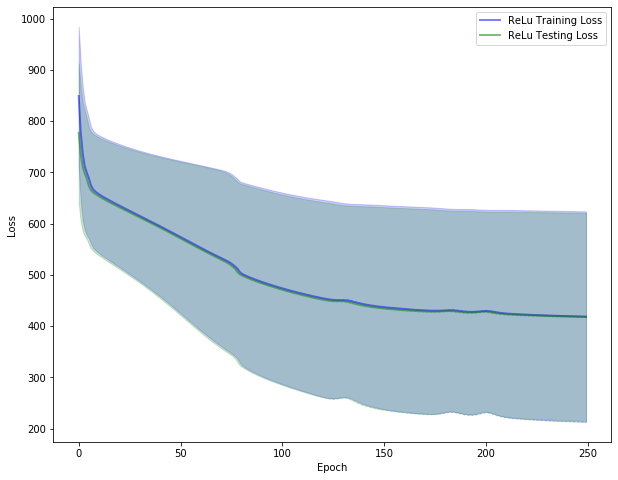

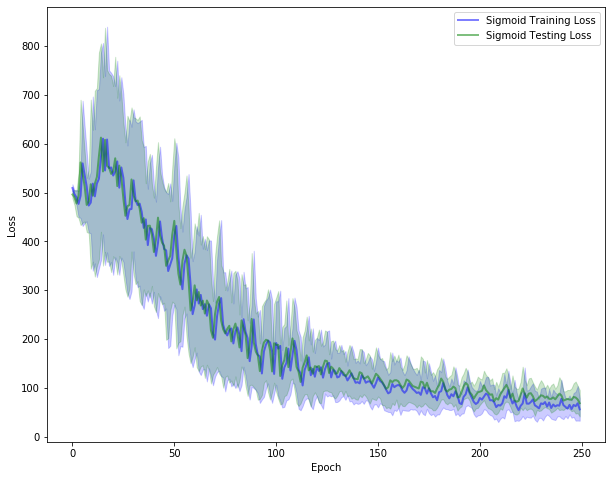

In [295]:
plot_loss(histories, 0, 'ReLu', train_history = True, test_history = True)
plot_loss(histories, 1, 'Sigmoid', train_history = True, test_history = True)

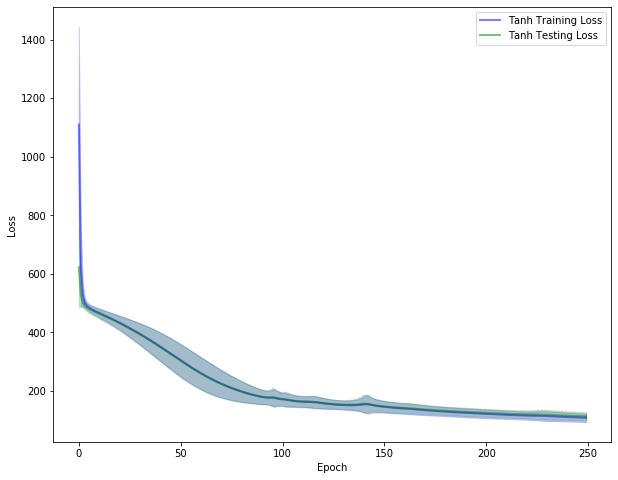

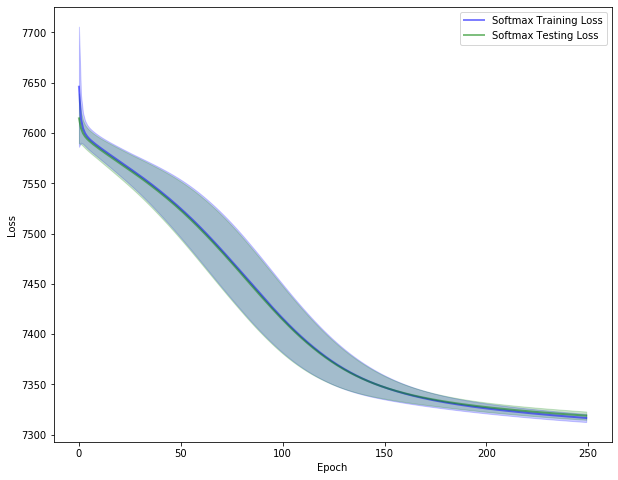

In [296]:
plot_loss(histories, 2, 'Tanh', train_history = True, test_history = True)
plot_loss(histories, 3, 'Softmax', train_history = True, test_history = True)

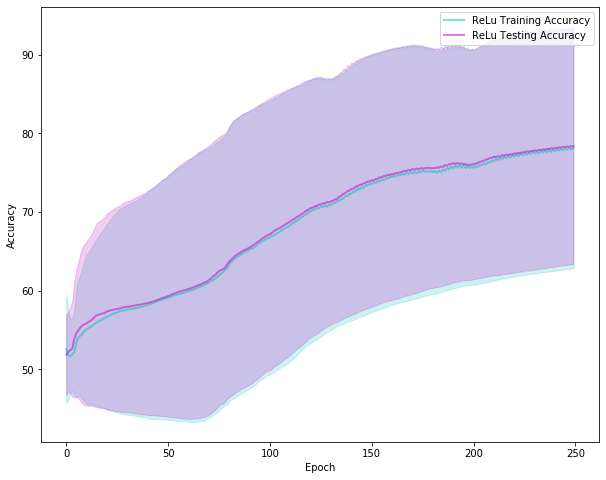

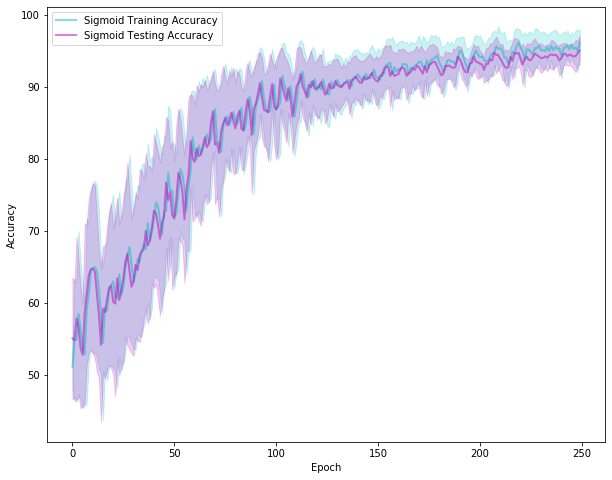

In [297]:
plot_acc(histories, 0, 'ReLu', train_history = True, test_history = True)
plot_acc(histories, 1, 'Sigmoid', train_history = True, test_history = True)

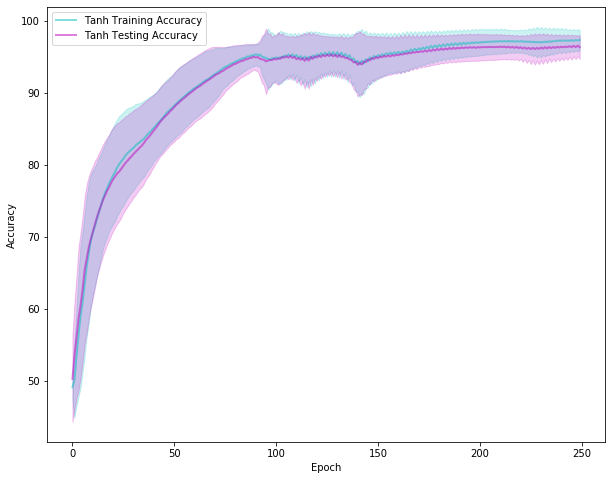

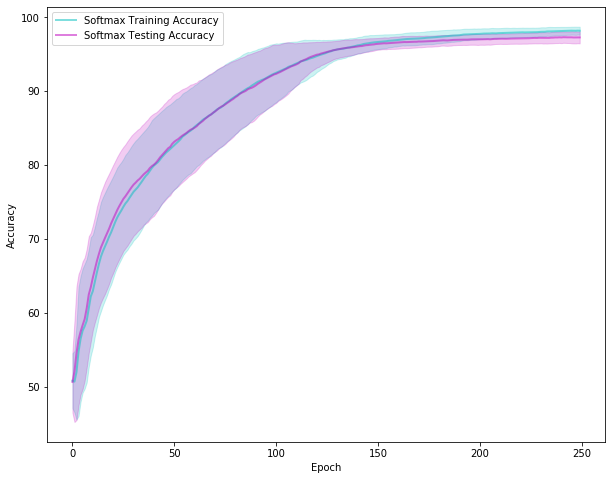

In [298]:
plot_acc(histories, 2, 'Tanh', train_history = True, test_history = True)
plot_acc(histories, 3, 'Softmax', train_history = True, test_history = True)